# Final size of a the simple epidemic model

The simple epidemic model is
$$\begin{aligned}
\frac{\mathrm{d} S}{\mathrm{d} t} &= - \beta S I,&
S(0) &= S_0 = N - I_0,\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta S I - \gamma I,&
I(0) &= I_0,\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma I,&
R(0) &= 0.
\end{aligned}$$

The basic reproduction number is
$$R_0 = \frac{\beta}{\gamma} S_0.$$

The model has
$$\frac{\mathrm{d} I}{\mathrm{d} t} =
\frac{\gamma I - \beta S I}{\beta S I} \frac{\mathrm{d} S}{\mathrm{d} t}.$$
For $I > 0$, this is
$$\frac{\mathrm{d} I}{\mathrm{d} t} =
\left(\frac{\gamma}{\beta S} - 1\right) \frac{\mathrm{d} S}{\mathrm{d} t},$$
so
$$I(t) - I(0) =
\frac{\gamma}{\beta} \left[\log S(t) - \log S(0)\right]
- S(t) + S(0).$$
Integrating with respect to $t$ gives
$$\log \frac{S(t)}{S_0}
= - R_0 \left[1 + \frac{I_0}{S_0} - \frac{S(t)}{S_0} - \frac{I(t)}{S_0}\right].$$

In the limit as $t \to +\infty$, $I(t) \to 0$, so
$$\log \frac{S_{\infty}}{S_0} = - R_0 \left[1 + \frac{I_0}{S_0} - \frac{S_{\infty}}{S_0}\right],$$
where $S_{\infty} = \lim_{t \to +\infty} S(t).$
Then
$$- R_0 \frac{S_{\infty}}{S_0} \mathrm{e}^{- R_0 \frac{S_{\infty}}{S_0}}
= - R_0 \mathrm{e}^{- R_0 \left(1 + \frac{I_0}{S_0}\right)},$$
Let $w = - R_0 \frac{S_{\infty}}{S_0}$
and $z = - R_0 \mathrm{e}^{- R_0 \left(1 + \frac{I_0}{S_0}\right)}$
so that
$$w \mathrm{e}^w = z,$$
then
$$w = \mathrm{W}(z),$$
where $\mathrm{W}(z)$ is the Lambert W function, or
$$- R_0 \frac{S_{\infty}}{S_0} 
= \mathrm{W}\left(- R_0 \mathrm{e}^{- R_0 \left(1 + \frac{I_0}{S_0}\right)}\right).$$
or
$$S_{\infty}
= - \frac{S_0}{R_0}
\mathrm{W}\left(- R_0 \mathrm{e}^{- R_0 \left(1 + \frac{I_0}{S_0}\right)}\right).$$

For the number recovered, $R_{\infty} = S_0 + I_0 - S_{\infty}$, so
$$R_{\infty}
= S_0 \left[1 + \frac{I_0}{S_0} + \frac{1}{R_0}
\mathrm{W}\left(- R_0 \mathrm{e}^{- R_0 \left(1 + \frac{I_0}{S_0}\right)}\right)\right].$$

In the limit as $I_0 \to 0$,
$$R_{\infty} = \begin{cases}
0 & \text{if $R_0 \leq 1$},\\
S_0 \left[1 + \frac{1}{R_0} \mathrm{W}(- R_0 \mathrm{e}^{- R_0})\right] & \text{if $R_0 > 1$}.
\end{cases}$$

Let's assume
$$\begin{aligned}
\beta &\sim \Gamma(0.03, 4),\\
\gamma &\sim \Gamma(0.01, 4),\\
S_0 &= N = 1.
\end{aligned}$$

In [1]:
from matplotlib import pyplot
import matplotlib.ticker
import numpy
import pandas
from scipy import linalg
from scipy import special
from scipy import stats
import seaborn
import statsmodels.api

import sensitivity_analysis


numpy.random.seed(1)


def model(beta, gamma, S_0=1, I_0=0):
    '''The final size $R_{\infty}$ for a simple SIR model.'''
    R_0 = beta * S_0 / gamma
    W = special.lambertw(- R_0 * numpy.exp(- R_0 * (1 + I_0 / S_0)))
    R_inf = numpy.real_if_close(S_0 * (1 + I_0 / S_0 + W / R_0))
    return numpy.where((I_0 == 0) & (R_0 <= 1), 0, R_inf)


# Let the transmission rate be a Gamma random variable.
transmission_rate_mean = 0.03
transmission_rate_shape = 4
transmission_rate_scale = transmission_rate_mean / transmission_rate_shape
transmission_rate = stats.gamma(transmission_rate_shape,
                                scale=transmission_rate_scale)

# Let the recovery rate be a Gamma random variable.
recovery_rate_mean = 0.01
recovery_rate_shape = 4
recovery_rate_scale = recovery_rate_mean / recovery_rate_shape
recovery_rate = stats.gamma(recovery_rate_shape,
                            scale=recovery_rate_scale)

parameters = dict(beta=transmission_rate,
                  gamma=recovery_rate)

# Uncertainty analysis

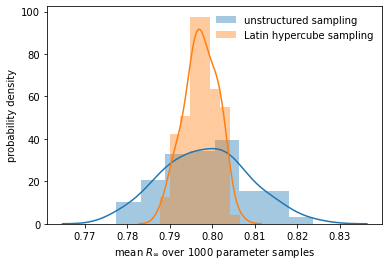

In [2]:
def get_mean(model, parameters, n_samples,
             sampler=sensitivity_analysis.samples_Latin_hypercube):
    X = sampler(parameters, n_samples)
    y = model(**X)
    return numpy.mean(y)


n_samples = 1000
n_runs = 100
means_unstructured = pandas.Series(
    [get_mean(model, parameters, n_samples,
              sampler=sensitivity_analysis.samples_unstructured)
     for _ in range(n_runs)],
    name='unstructured sampling')
means_LHS = pandas.Series(
    [get_mean(model, parameters, n_samples,
              sampler=sensitivity_analysis.samples_Latin_hypercube)
     for _ in range(n_runs)],
    name='Latin hypercube sampling')

ax = seaborn.distplot(means_unstructured, label=means_unstructured.name)
seaborn.distplot(means_LHS, label=means_LHS.name, ax=ax)
ax.set_xlabel(f'mean $R_{{\infty}}$ over {n_samples} parameter samples')
ax.set_ylabel('probability density')
_ = ax.legend()

In [3]:
n_samples = (10, 20, 50,
             100, 200, 500,
             1000, 2000, 5000,
             10000)
n_runs = 100
means = pandas.concat({n: pandas.Series([get_mean(model, parameters, n)
                                         for _ in range(n_runs)])
                       for n in n_samples},
                      axis='index', names=['number of samples'])

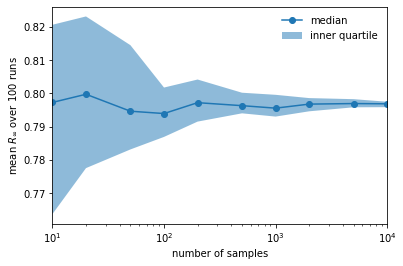

In [4]:
def plot_median_and_quartiles(df):
    grouper = df.groupby('number of samples')
    median = grouper.median()
    ax = median.plot(label='median', marker='o', logx=True)
    Q = grouper.quantile([0.25, 0.75]).unstack()
    ax.fill_between(Q.index, Q[0.25], Q[0.75],
                    label='inner quartile', alpha=0.5)
    ax.legend()
    return ax


ax = plot_median_and_quartiles(means)
_ = ax.set_ylabel(f'mean $R_{{\infty}}$ over {n_runs} runs')

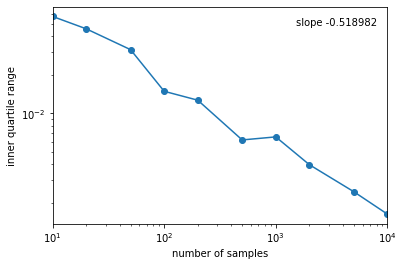

In [5]:
def IQR(x):
    return x.quantile(0.75) - x.quantile(0.25)


def estimate_slope(ser, logx=False, logy=False):
    '''Estimate b so that y = a x ^ b'''
    x = ser.index.get_level_values(-1)
    if logx:
        x = numpy.log10(x)
    X = statsmodels.api.add_constant(x)
    y = ser
    if logy:
        y = numpy.log10(y)
    lm = statsmodels.api.OLS(y, X).fit()
    return lm.params[1]


def plot_IQR(df):
    grouper = df.groupby('number of samples')
    iqr = grouper.apply(IQR)
    ax = iqr.plot(marker='o', logx=True, logy=True)
    ax.set_ylabel('inner quartile range')
    slope = estimate_slope(iqr, logx=True, logy=True)
    ax.annotate(f'slope {slope:g}', (0.97, 0.95),
                horizontalalignment='right',
                verticalalignment='top',
                xycoords='axes fraction')
    return ax


ax = plot_IQR(means)

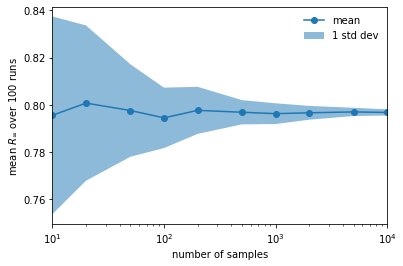

In [6]:
def plot_mean_and_std(df):
    grouper = df.groupby('number of samples')
    mean = grouper.mean()
    ax = mean.plot(label='mean', marker='o', logx=True)
    std = grouper.std()
    ax.fill_between(mean.index, mean - std, mean + std,
                    label='1 std dev', alpha=0.5)
    ax.legend()
    return ax


ax = plot_mean_and_std(means)
_ = ax.set_ylabel(f'mean $R_{{\infty}}$ over {n_runs} runs')

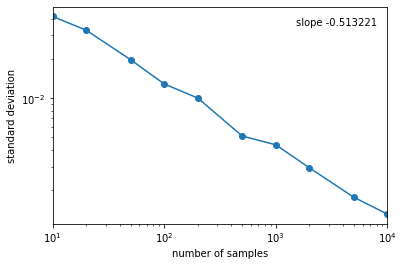

In [7]:
def plot_std(df):
    grouper = df.groupby('number of samples')
    std = grouper.std()
    ax = std.plot(marker='o', logx=True, logy=True)
    ax.set_ylabel('standard deviation')
    slope = estimate_slope(std, logx=True, logy=True)
    ax.annotate(f'slope {slope:g}', (0.97, 0.95),
                horizontalalignment='right',
                verticalalignment='top',
                xycoords='axes fraction')
    return ax


ax = plot_std(means)

# Sensitivity analysis

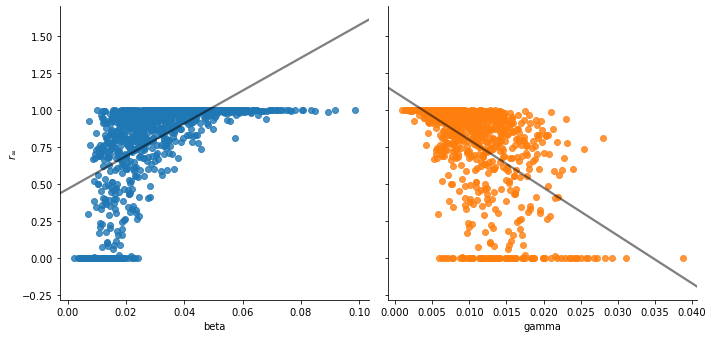

In [8]:
fg = sensitivity_analysis.scatterplots(model, parameters, n_samples=1000)
_ = fg.set_ylabels(r'$r_{\infty}$')

In [9]:
def bold_sum(s):
    '''Made the 'Sum' row bold.'''
    is_sum = (s.index == 'Sum')
    return ['font-weight: bold' if v else '' for v in is_sum]


def display_with_sums(table):
    '''Add column sums and display.'''
    table = table.copy()
    table.loc['Sum'] = table.sum()
    return table.style.apply(bold_sum)


n_samples = 1000
table = {}
# table[r'$S^2$'] = sensitivity_analysis.sensitivity(
#     model, parameters, n_samples, normalized=False) ** 2
# table[r'$\beta^2$'] = sensitivity_analysis.linreg_coefficients(
#     model, parameters, n_samples, normalized=False) ** 2
# table[r'$\nu$'] = sensitivity_analysis.DGSM(
#     model, parameters, n_samples, normalized=False)
table[r'$S_{\sigma}^2$'] = sensitivity_analysis.sensitivity(
    model, parameters, n_samples) ** 2
table[r'$\beta_{\sigma}^2$'] = sensitivity_analysis.linreg_coefficients(
    model, parameters, n_samples) ** 2
table[r'$\nu_{\sigma}$'] = sensitivity_analysis.DGSM(
    model, parameters, n_samples)
(S, _, S_T, _) = sensitivity_analysis.Sobol_indexes(
    model, parameters, n_samples)
table[r'$S$'] = S
table[r'$S_{\text{T}}$'] = S_T
table[r'$\rho_{\text{partial rank}}$'] = sensitivity_analysis.PRCC(
    model, parameters, n_samples)
table = pandas.DataFrame(table)
display_with_sums(table)

,$S_{\sigma}^2$,$\beta_{\sigma}^2$,$\nu_{\sigma}$,$S$,$S_{\text{T}}$,$\rho_{\text{partial rank}}$
beta,0.122511,0.305426,3.16213,0.518618,0.711661,0.941229
gamma,0.12255,0.320011,0.662742,0.316508,0.491182,-0.941767
Sum,0.245061,0.625437,3.82487,0.835127,1.20284,-0.000537425


In [10]:
def display_Sobol_indexes(S, S_PE, S_T, S_T_PE, alpha=0.5):
    '''Display the Sobol' indexes S and S_T in a nice table.'''
    table = pandas.concat((S, S_PE, S_T, S_T_PE), axis='columns')
    CI_percent = 100 * (1 - alpha)
    columns = pandas.MultiIndex.from_product(
        (('First-order index ($S$)', r'Total-order index ($S_{\text{T}}$)'),
         ('Estimate', f'{CI_percent:g}% probable error')))
    table.set_axis(columns, axis='columns', inplace=True)
    table.loc['Sum'] = table.sum()
    # Don't show the sum of the probable errors.
    estimates = (columns.get_level_values(1) == 'Estimate')
    table.loc['Sum', ~estimates] = ''
    display(table.style.apply(bold_sum))


n_samples = 1000
alpha = 0.5
(S, S_PE, S_T, S_T_PE) = sensitivity_analysis.Sobol_indexes(
    model, parameters, n_samples, alpha=alpha)
display_Sobol_indexes(S, S_PE, S_T, S_T_PE, alpha=alpha)

## Accuracy vs. number of model evaluations

In [11]:
class SensitivityMeasure:
    '''Parent class for sensitivity measures.'''


class SquaredNormalizedLocalSensitivity(SensitivityMeasure):
    '''The squared sigma-normalized local sensitivity.'''

    label = r'$S_{\sigma}^2$'
    
    @staticmethod
    def calc(model, parameters, n_samples):
        '''Calculate the sensitivity measure.'''
        return sensitivity_analysis.sensitivity(model, parameters, n_samples) ** 2

    @staticmethod
    def n_evals(n_samples, n_parameters):
        '''The number of model evaluations.'''
        return n_samples + n_parameters + 1


class SquaredNormalizedLinRegCoef(SensitivityMeasure):
    '''The squared sigma-normalized linear regression coefficients.'''

    label = r'$\beta_{\sigma}^2$'

    @staticmethod
    def calc(model, parameters, n_samples):
        '''Calculate the sensitivity measure.'''
        return sensitivity_analysis.linreg_coefficients(model, parameters, n_samples) ** 2

    @staticmethod
    def n_evals(n_samples, n_parameters):
        '''The number of model evaluations.'''
        return n_samples


class NormalizedDGSM(SensitivityMeasure):
    '''The sigma-normalized derivative based global sensitivity measure.'''

    label = r'$\nu_{\sigma}$'

    @staticmethod
    def calc(model, parameters, n_samples):
        '''Calculate the sensitivity measure.'''
        return sensitivity_analysis.DGSM(model, parameters, n_samples)

    @staticmethod
    def n_evals(n_samples, n_parameters):
        '''The number of model evaluations.'''
        return (n_parameters + 1) * n_samples


class SobolIndex:
    '''Parent class for Sobol' indexes.'''

    @staticmethod
    def get(model, parameters, n_samples):
        '''Get the first-order and total-order Sobol' indexes.'''
        (S, _, S_T, _) = sensitivity_analysis.Sobol_indexes(model, parameters, n_samples)
        return (S, S_T)
    
    @staticmethod
    def n_evals(n_samples, n_parameters):
        '''The number of model evaluations.'''
        return (n_parameters + 2) * n_samples


class FirstOrderSobolIndex(SensitivityMeasure, SobolIndex):
    '''The first-order Sobol' index.'''

    label = '$S$'

    @classmethod
    def calc(cls, model, parameters, n_samples):
        '''Calculate the sensitivity measure.'''
        (S, _) = super().get(model, parameters, n_samples)
        return S


class TotalOrderSobolIndex(SensitivityMeasure, SobolIndex):
    '''The total-order Sobol' index.'''

    label = r'$S_{\mathrm{T}}$'

    @classmethod
    def calc(cls, model, parameters, n_samples):
        '''Calculate the sensitivity measure.'''
        (_, S_T) = super().get(model, parameters, n_samples)
        return S_T


class PartialRankCorrCoef(SensitivityMeasure):
    '''The partial rank correlation coefficient.'''
    
    label = r'$\rho_{\mathrm{partial\ rank}}$'
    
    def calc(model, parameters, n_samples):
        '''Calculate the sensitivity measure.'''
        return sensitivity_analysis.PRCC(model, parameters, n_samples)

    def n_evals(n_samples, n_parameters):
        '''The number of model evaluations.'''
        return n_samples

In [12]:
def get_do_sample_levels(model, parameters, n_samples, n_runs):
    '''Return a function that computes the sensitivities of the model.'''
    n_parameters = len(parameters)
    def do_sample_levels(cls):
        def do_runs(n_samples):
            return pandas.DataFrame([cls.calc(model, parameters, n_samples)
                                     for _ in range(n_runs)])
        def n_evals(n_samples):
            return cls.n_evals(n_samples, n_parameters)
        df = pandas.concat({n_evals(n): do_runs(n) for n in n_samples},
                           axis='index', names=['model evaluations'])
        df.label = cls.label
        return df
    return do_sample_levels


n_samples = (10, 20, 50,
             100, 200, 500,
             1000, 2000, 5000,
             10000)
n_runs = 100
do_sample_levels = get_do_sample_levels(model, parameters, n_samples, n_runs)
measures = SensitivityMeasure.__subclasses__()
measure_values = pandas.concat(
    {cls.label: do_sample_levels(cls) for cls in measures},
    axis='index', names=['measure'])

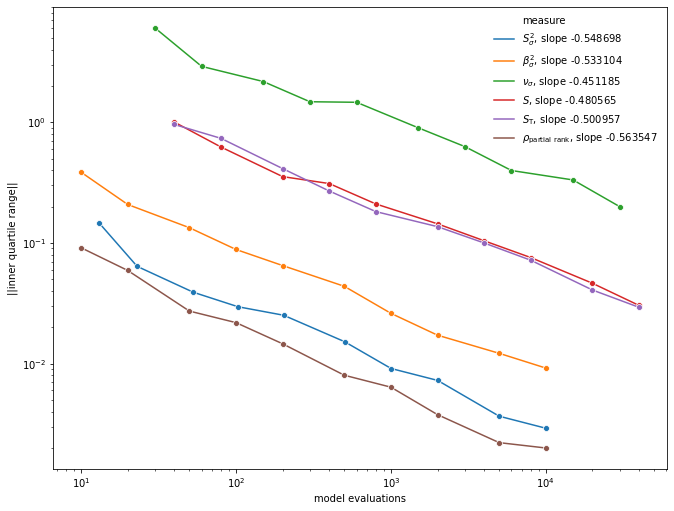

In [13]:
def IQR_norm(df, ord=2):
    '''The norm of the inner quartile range of the rows of data.'''
    return numpy.linalg.norm(IQR(df), ord=ord)


def plot_norm(data, norm, ylabel, logx=False, logy=True, **kwds):
    assert len(data.index.names) == 3
    (hue, x) = data.index.names[:2]
    y = ylabel
    grouper = data.groupby([hue, x], sort=False)
    val = grouper.apply(norm, **kwds)
    df = val.rename(y, inplace=False).reset_index()
    # Add slope to the outer level names for the legend.
    slope = val.groupby(hue, sort=False).apply(estimate_slope, logx=logx, logy=logy)
    hue_new = {k: f'{k}, slope {v:g}'
               for (k, v) in slope.items()}
    df.replace({hue: hue_new}, inplace=True)
    (fig, ax) = pyplot.subplots(figsize=(11, 8.5))
    seaborn.lineplot(data=df, x=x, y=y, hue=hue,
                     marker='o', ax=ax)
    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')
    return ax


def plot_IQR_norm(data, **kwds):
    ylabel = '||inner quartile range||'
    return plot_norm(data, IQR_norm, ylabel, **kwds)


_ = plot_IQR_norm(measure_values, logx=True)

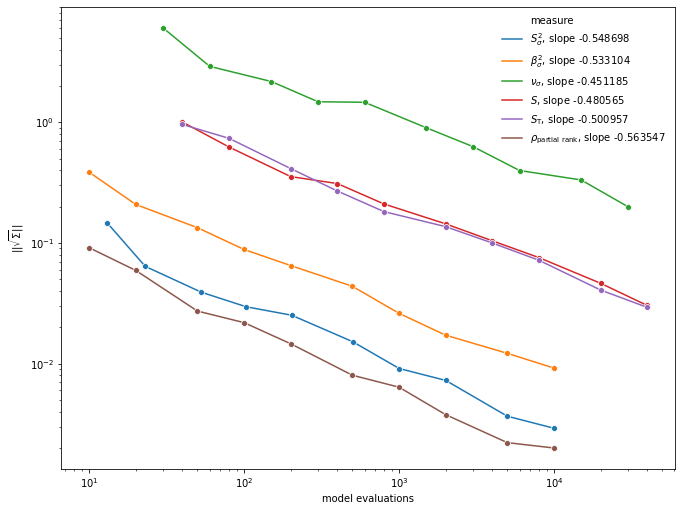

In [14]:
def sqrt_cov_norm(df, ord=2):
    '''The norm of the square root of the covariance matrix.'''
    return numpy.linalg.norm(linalg.sqrtm(df.cov()), ord=ord)


def plot_sqrt_cov_norm(data, **kwds):
    ylabel = r'$||\sqrt{\Sigma}\||$'
    return plot_norm(data, IQR_norm, ylabel, **kwds)


_ = plot_sqrt_cov_norm(measure_values, logx=True)

How often does a given parameter have the most significant sensitivity value?

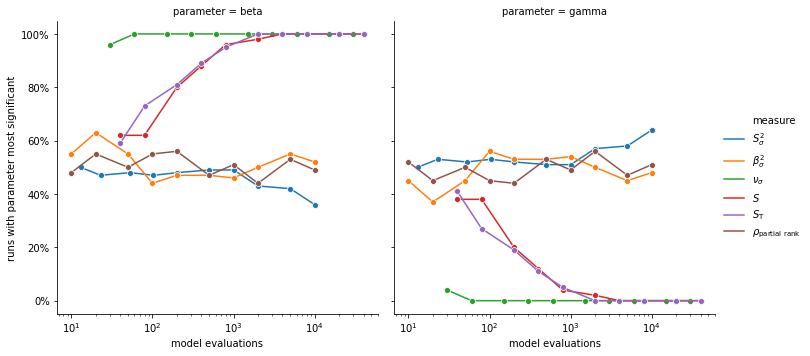

In [15]:
def plot_most_sig(data, logx=False):
    assert len(data.index.names) == 3
    (hue, x) = data.index.names[:2]
    y = 'runs with parameter most significant'
    col = 'parameter'
    order = numpy.argsort(numpy.abs(data))
    order_max = data.shape[1] - 1
    n_most_sig = (order == order_max).sum(level=[hue, x])
    grouper = order.groupby([hue, x], sort=False)
    p_most_sig = n_most_sig / grouper.count()
    ser = p_most_sig.rename_axis(columns=col).stack()
    df = ser.rename(y, inplace=False).reset_index()
    fg = seaborn.relplot(data=df, x=x, y=y, hue=hue, col=col,
                         kind='line', marker='o')
    if logx:
        fg.set(xscale='log')
    for ax in fg.axes.flat:
        ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
    return fg


_ = plot_most_sig(measure_values, logx=True)

## Accuracy vs. number of parmeters

Adding $j$ non-influential parameters $Z_0, ..., Z_{j - 1}$,
the model is
$$\hat{R}_{\infty}(\beta, \gamma, Z_0, ..., Z_{j - 1}) = R_{\infty}(\beta, \gamma)$$

In [16]:
def model_extended(beta, gamma, *args, **kwds):
    '''Drop all arguments and keywords beyond beta and gamma.'''
    return model(beta, gamma)


def get_get_parameters(parameters):
    def get_parameters(n_parameters):
        n_dummies = n_parameters - len(parameters)
        dummies = {f'Z_{i}': stats.norm(0, 1)
                   for i in range(n_dummies)}
        return dict(**parameters, **dummies)
    return get_parameters


def get_do_parameter_levels(model_extended, parameters, n_parameters, n_samples, n_runs):
    '''Return a function that computes the sensitivities of the model.'''
    def do_parameter_levels(cls):
        def get_parameters_extended(n_parameters):
            n_dummies = n_parameters - len(parameters)
            dummies = {f'Z_{i}': stats.norm(0, 1)
                       for i in range(n_dummies)}
            return dict(**parameters, **dummies)
        def do_runs(n_parameters):
            parameters_extended = get_parameters_extended(n_parameters)
            df = pandas.DataFrame(
                [cls.calc(model_extended, parameters_extended, n_samples)
                 for _ in range(n_runs)])
            return df[parameters.keys()]
        df = pandas.concat({n: do_runs(n) for n in n_parameters},
                           axis='index', names=['parameters'])
        df.label = cls.label
        return df
    return do_parameter_levels


n_parameters = (2, 5,
                10, 20, 50,
                100)
n_samples = 1000
n_runs = 100
do_parameter_levels = get_do_parameter_levels(model_extended, parameters,
                                              n_parameters, n_samples, n_runs)
measures = SensitivityMeasure.__subclasses__()
measure_values_p = pandas.concat(
    {cls.label: do_parameter_levels(cls) for cls in measures},
    axis='index', names=['measure'])

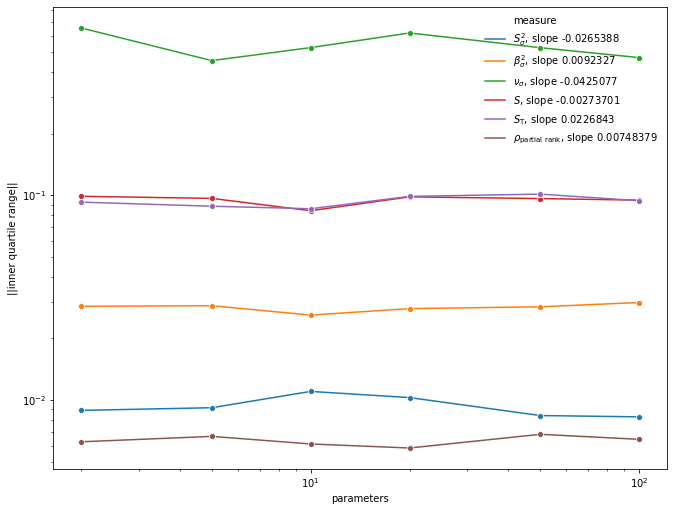

In [17]:
_ = plot_IQR_norm(measure_values_p, logx=True)

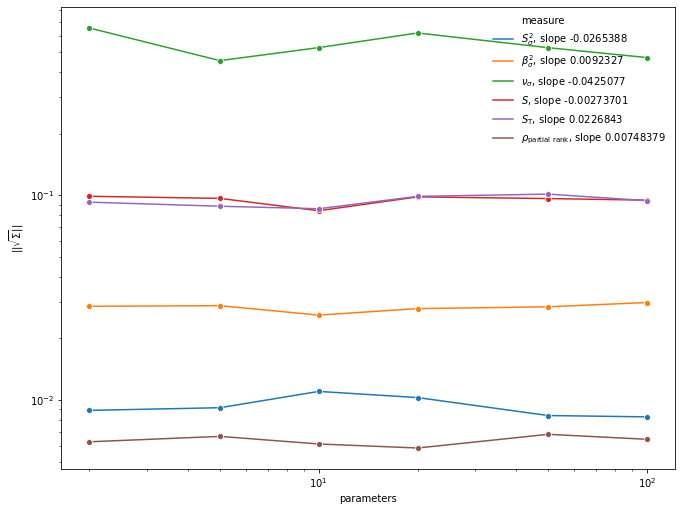

In [18]:
_ = plot_sqrt_cov_norm(measure_values_p, logx=True)

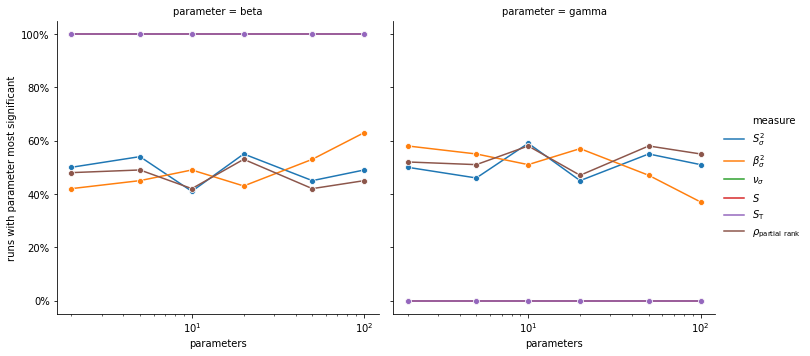

In [19]:
_ = plot_most_sig(measure_values_p, logx=True)

# Conclusions

If runs are expensive or the number of parameters is large, $\rho_{\text{partial rank}}$ and $\beta_{\sigma}$ are preferred for using fewer model evaluations and can even be simultaneously computed from the same samples.

If runs are cheap, $S$ and $S_T$ are preferred.

The error on $\nu_{\sigma}$ is expensive to compute and the variation is large.

Increasing the number of parameters does not seem to increase the variation in estimating any of the sensitivity measures.